In [57]:
from typing import Dict, List, Tuple, Union
from skimage import exposure, img_as_ubyte
import rasterio
import pathlib
import re
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [58]:
def load_landsat_image(
    img_folder: Union[str, None],
    bands: Union[List[str], None]
) -> Dict:
    """
    Take a folder path and return a dict with the raw vectors extracted from the Earth Engine.
    """
    # Dictionary to save the image.
    images_dict = {}

    if img_folder:
        # Use the provided path.
        path = pathlib.Path(img_folder)
    else:
        # Get the path to retrieve.
        path = pathlib.Path(__file__).parent

    # Get the list of all files.
    files = [f.name for f in path.glob('**/*.tif')]
    # Parse all of filenames to get the unique ones.
    files = set([re.search('_[0-9](.*)[0-9]_', x).group() for x in files])
    # Dict of images to return.
    images_dict = {}

    # Iterate over the files.
    for pat in files:
        image = {}
        # Iterate over the bands.
        for band in bands:
            file = next(path.glob(f'*{pat}{band}.tif'))
            #print(f'Opening file {file}')
            ds = rasterio.open(file)
            image.update({band: ds.read(1)})
        # Update the main dict.
        images_dict.update(
            {pat.replace('_','') : image}
        )

    return images_dict

def convert_to_eight_bits(
    img: Union[Dict, None]
) -> np.array:
    """
    To reescale image to 8 bits.
    """
    img_stack = np.stack(
        [img['B4'], img['B3'], img['B2'], img['B8']]
        , axis=-1)

    scaled_img = img_as_ubyte(
        exposure.rescale_intensity(img_stack)
    )
    
    return scaled_img

def stack_to_dict(
    stack: Union[np.stack, None],
    bands: List[str] = ['B4','B3','B2','B8']
) -> Dict:
    """
    Unstack the rescaled dictionary.
    """
    dimension = stack.shape

    # Create the arrays of the bands.
    bands_lst = [[] for band in bands]
    
    for i in range(dimension[0]):
        for j in range(dimension[1]):
            # R
            bands_lst[0].append(
                stack[i][j][0]
            )
            # G
            bands_lst[1].append(
                stack[i][j][1]
            )
            # B
            bands_lst[2].append(
                stack[i][j][2]
            )
            # NIR
            bands_lst[3].append(
                stack[i][j][3]
            )
    
    # Create
    unstack_dict = {bands[i] : bands_lst[i]  for i in range(len(bands))}
            
    return unstack_dict

def get_center_pixels(image_data, diag_length=(3,3)):

    drawing = image_data.copy()
    h, w, _ = image_data.shape
    rows, cols = diag_length
    
    center = (round(h/2), round(w/2))

    square = image_data[center[0]-cols:center[0]+cols, center[1]-rows:center[1]+rows]

    cv2.rectangle(drawing, (center[0]-cols, center[1]-rows), (center[0]+cols, center[1]+rows), (255, 255, 255))
    plt.imshow(drawing)

    return square

def calculate_ndvi(image_data):
    
    b4 = image_data["B4"]
    b8 = image_data["B8"]

    visr = b4.read(1).astype("float64")
    nir = b8.read(1).astype("float64")

    ndvi_matrix=np.where((nir+visr)==0., 0, (nir-visr)/(nir+visr))

    fig, ax = plt.subplots()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    im = ax.imshow(ndvi_matrix, cmap='viridis')
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()

def calculate_savi(image_data):

    b4 = image_data["B4"]
    b8 = image_data["B8"]

    l=0

    visr = b4.read(1).astype("float64")
    nir = b8.read(1).astype("float64")

    savi_matrix=np.where((visr+nir + l)==0., 0, ((nir-visr)/(visr+nir + l) ) * (1+l))

    fig, ax = plt.subplots()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im = ax.imshow(savi_matrix, cmap='RdYlGn')

    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()

    return savi_matrix


def calculate_gci(image_data):

    b3 = image_data["B3"]
    b8 = image_data["B8"]

    visg = b3.read(1).astype('float64')
    nir = b8.read(1).astype('float64')

    gci_matrix=np.where((visg)==0., 0, (nir)/(visg) - 1)

    fig, ax = plt.subplots()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(gci_matrix, cmap='RdYlGn')
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()

In [59]:
IMGS_PATH = '/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba1-1/'
band_labels = ["B4", "B3", "B2", "B8"]
images = load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())

In [60]:
test = convert_to_eight_bits(images[img_keys[0]])

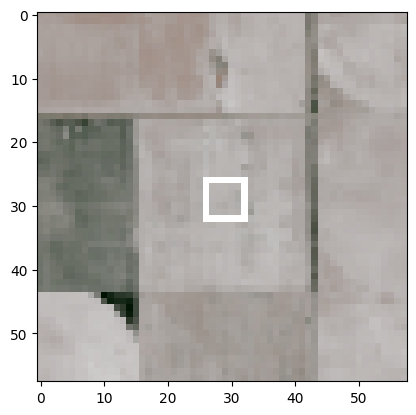

In [61]:
test_region = get_center_pixels(test)

In [62]:
test_region

array([[[36, 27, 22, 80],
        [40, 28, 22, 86],
        [37, 25, 20, 82],
        [36, 26, 20, 83],
        [38, 27, 21, 84],
        [35, 25, 20, 79]],

       [[35, 27, 21, 81],
        [37, 26, 21, 82],
        [36, 25, 20, 80],
        [36, 26, 19, 81],
        [38, 27, 21, 84],
        [35, 26, 21, 83]],

       [[38, 28, 21, 84],
        [38, 26, 20, 83],
        [37, 26, 20, 84],
        [36, 25, 20, 82],
        [42, 30, 24, 89],
        [36, 31, 23, 97]],

       [[41, 30, 23, 89],
        [38, 27, 22, 84],
        [37, 26, 19, 84],
        [38, 26, 21, 86],
        [42, 30, 24, 90],
        [35, 31, 21, 98]],

       [[41, 31, 23, 95],
        [39, 28, 21, 87],
        [37, 27, 20, 91],
        [40, 30, 23, 96],
        [36, 28, 22, 88],
        [32, 27, 21, 90]],

       [[40, 30, 24, 90],
        [39, 28, 22, 86],
        [37, 27, 20, 84],
        [40, 30, 23, 88],
        [38, 27, 21, 83],
        [38, 30, 24, 88]]], dtype=uint8)

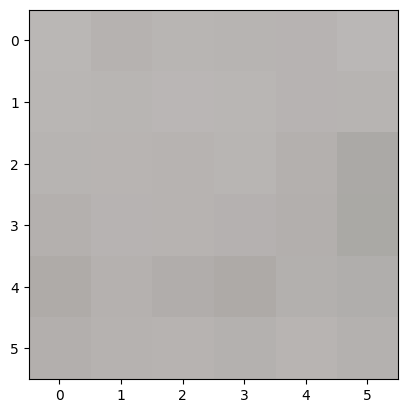

In [63]:
plt.imshow(test_region)

In [64]:
test_region_bands = stack_to_dict(test_region)
test_region_bands["B4"]

[36,
 40,
 37,
 36,
 38,
 35,
 35,
 37,
 36,
 36,
 38,
 35,
 38,
 38,
 37,
 36,
 42,
 36,
 41,
 38,
 37,
 38,
 42,
 35,
 41,
 39,
 37,
 40,
 36,
 32,
 40,
 39,
 37,
 40,
 38,
 38]

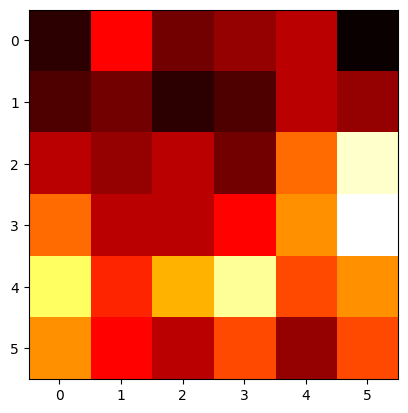

In [67]:
plt.imshow(np.array(test_region_bands["B8"]).reshape(6,6,1), cmap="hot")

TypeError: Invalid shape (36,) for image data

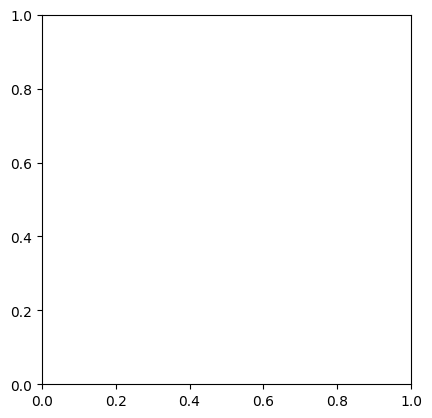

In [66]:
plt.imshow(test_region_bands["B2"])